# Google Places Spatial Join
Case study of joining data to street segment using Google Places data. Three parts:
1. Data Ingestion
2. Spatial Join of Google Places to Road Segments
3. Aggregating data by osmid 

In [31]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from shapely.geometry import box, Point
import rtree

from fiona.crs import from_epsg
%matplotlib inline

### I. Import shapefiles and convert to appropriate coordinate system

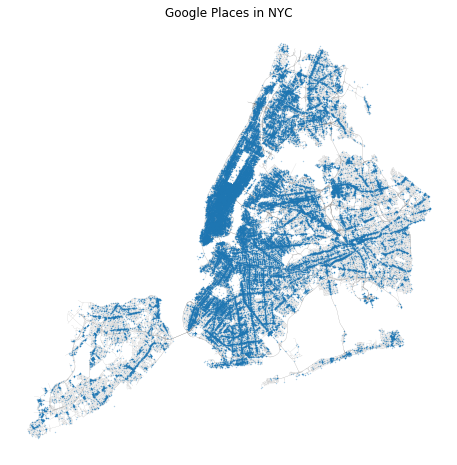

In [29]:
# Ingest data and convert to long island state plane so we can use ft as units
segs = gpd.read_file('../road_network_data/osm/osm_w_collisions/edges/edges.shp').to_crs({'init': 'epsg:2263'})
nodes = gpd.read_file('../road_network_data/osm/osm_w_collisions/nodes/nodes.shp').to_crs({'init': 'epsg:2263'})

# Get schools from CSV
gplaces = pd.read_csv('out/Google_Places_NYC.csv')

#Transform to GeoDataFrame
gplaces['geometry'] = gplaces.apply(lambda x: Point(float(x['geometry.location.lng']), float(x['geometry.location.lat'])), axis=1)
gplaces = gpd.GeoDataFrame(gplaces, crs=from_epsg(4326))
gplaces = gplaces.to_crs(epsg=2263)

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Google Places in NYC')
segs.plot(color='black', ax= ax, lw=0.1, zorder=-1, alpha=0.5)
#nodes.plot(markersize=10, ax= ax)
gplaces.plot(color='tab:blue', markersize=0.1, ax=ax, alpha=0.5)
ax.axis('off')

plt.show()

### II. "Spatially join" road data to Google Places

Not sure if join by closest distance can be done with GeoPandas, so I'm calculating the closest road segment to each Google Place and assigning it the OSM id.

In [32]:
index = rtree.Rtree()
for idx, geometry in enumerate(segs.geometry):
    index.insert(idx, geometry.bounds)

def closest_segment_id_rtree(point, index, segments):
    match = list(index.nearest((point.x, point.y, point.x, point.y)))
    if len(match):
        return segments.loc[segments.loc[match, 'geometry'].distance(point).idxmin(),'id']
    else:
        return None

In [33]:
len(segs), len(gplaces)

(91666, 130565)

In [34]:
%time gplaces['segid'] = gplaces.geometry.apply(lambda x: closest_segment_id_rtree(x, index, segs))

CPU times: user 2min 23s, sys: 790 ms, total: 2min 24s
Wall time: 2min 24s


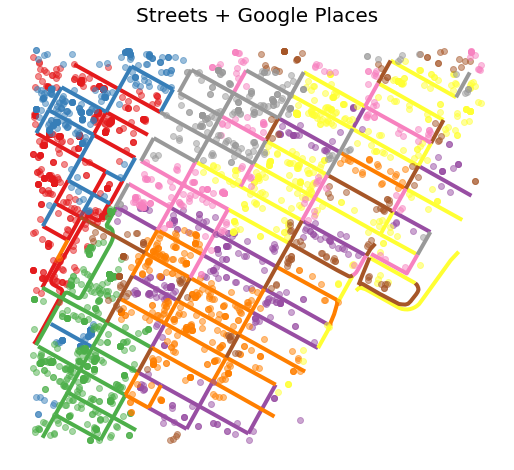

In [37]:
#Set a boundary to plot part of the city (Midtown East)
minx, miny, maxx, maxy = (990149.818502453, 211876.76283257356, 994651.4676882139, 215780.79272242662)
sample_bounds = box(minx, miny, maxx, maxy)
gplaces_sample = gplaces[gplaces.within(sample_bounds)]
segs_sample = segs[segs.within(sample_bounds)]

# visualize joined data
fig, ax = plt.subplots(figsize=(12,8))
n=len(gplaces_sample.segid.unique())
color=iter(cm.Set1(np.linspace(0,1,n)))

for x in gplaces_sample.segid.unique():
    c=next(color)
    gplaces_sample[gplaces_sample.segid == x].plot(ax=ax, facecolor=c, alpha=0.5)
    segs_sample[segs_sample.id == x].plot(edgecolor=c, ax= ax, lw=4, zorder=-1, alpha=1)
    
ax.set_title('Streets + Google Places', fontsize=20)
ax.axis('off')
plt.show()

### III. TODO: Aggregate Google Places data to SoP variables per segment


In [73]:
# available google place types
gplaces.columns[-96:-1]

Index(['accounting', 'art_gallery', 'atm', 'bakery', 'bank', 'bar',
       'beauty_salon', 'bicycle_store', 'book_store', 'bowling_alley',
       'bus_station', 'cafe', 'campground', 'car_dealer', 'car_rental',
       'car_repair', 'car_wash', 'casino', 'cemetery', 'church', 'city_hall',
       'clothing_store', 'convenience_store', 'courthouse', 'dentist',
       'department_store', 'doctor', 'electrician', 'electronics_store',
       'embassy', 'establishment', 'finance', 'fire_station', 'florist',
       'food', 'funeral_home', 'furniture_store', 'gas_station',
       'general_contractor', 'grocery_or_supermarket', 'gym', 'hair_care',
       'hardware_store', 'health', 'hindu_temple', 'home_goods_store',
       'hospital', 'insurance_agency', 'jewelry_store', 'laundry', 'lawyer',
       'library', 'liquor_store', 'local_government_office', 'locksmith',
       'lodging', 'meal_delivery', 'meal_takeaway', 'mosque', 'movie_rental',
       'movie_theater', 'moving_company', 'museum', 'n

I will only use the types I directly downloaded

In [78]:
sop_from_gplace = {
    'gymfitns' : ['gym'],
    'movieth' : ['movie_theater'],
    'recoher' : ['bowling_alley'],
    'comctlib' : ['library'],
    'mustheat' : ['museum'],
    'pubcivic': ['post_office', 'police', 'courthouse'],
    'civother': ['local_government_office', 'fire_station', 'city_hall'],
    'religion' : ['place_of_worship'],
    'medicine' : ['hospital'], #doctor, dentist?
    #'insother' : [],
    'softgood' : ['clothing_store', 'shoe_store', 'pharmacy'],
    'hardgood' : ['furniture_store', 'electronics_store', 'hardware_store', 'home_goods_store', 'jewelry_store'],
    'othrrtail' : ['department_store'],
    'restaurant' : ['restaurant'],
    #'fastfood' : [],
    #'smlgrcer' : [],
    'mlgrcer' : ['grocery_or_supermarket', 'supermarket'],
    'financl' : ['bank'],
    'hotelhos' : ['lodging'],
    'cardeal' : ['car_dealer'],
    'gasserv' : ['gas_station'],
    'bikeretl' : ['bicycle_store'],
    #'localstre' : [],
    'chainstre' : ['department_store'],
    #'commothr' : [],
    'service' : ['laundry', 'insurance_agency', 'funeral_home'],
    #'ofseroth': [],
    #'bigbox' : [],
    'shopmall' : ['shopping_mall'],
    #'strpmall' : [],
    #'drivthru' : [],
    'barsclub' : ['bar', 'night_club'],
    #'adultuse' : [],
    #'chckcash' : [],
    'liquorst' : ['liquor_store'],
    'restarnt' : ['restaurant'],
    'coffshop' : ['cafe'],
    'libbkstr' : ['library', 'book_store'],
    'cornerst': ['convenience_store'],
    'artgllry': ['art_gallery']
}

#### Aggregate

In [116]:
ptypes_in_use = list(set([item for sublist in sop_from_gplace.values() for item in sublist]))

In [117]:
#Aggregate all place types in use to segment id, 1 if there is 1 or more places of that type, 0 if none
final_df = (gplaces.groupby('segid')[ptypes_in_use].sum() > 0).astype(int)

In [118]:
final_df.head()

,restaurant,laundry,department_store,pharmacy,police,local_government_office,lodging,museum,bar,book_store,...,place_of_worship,art_gallery,bank,city_hall,car_dealer,fire_station,supermarket,electronics_store,hospital,shopping_mall
segid,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
#Multiple columns translate to one or more SoP variables
def get_sop_vars(df, transform_dict):
    new_df = pd.DataFrame(index=df.index)
    for k, v in transform_dict.items():
        new_df[k] = (df[v].sum(axis=1) > 0).astype(int)
    return new_df

In [120]:
final_df = get_sop_vars(final_df, sop_from_gplace)
final_df.head()

,gymfitns,movieth,recoher,comctlib,mustheat,pubcivic,civother,religion,medicine,softgood,...,chainstre,service,shopmall,barsclub,liquorst,restarnt,coffshop,libbkstr,cornerst,artgllry
segid,,,,,,,,,,,,,,,,,,,,,
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [121]:
final_df.to_csv('joined_gplaces.csv')

### Plot result

In [125]:
variables = list(sop_from_gplace.keys())

segs_joined = pd.merge(segs, final_df, left_on='id', right_index=True, how='left', suffixes=('_x', '')).fillna(0)
segs_joined[variables] = segs_joined[variables].astype(int)

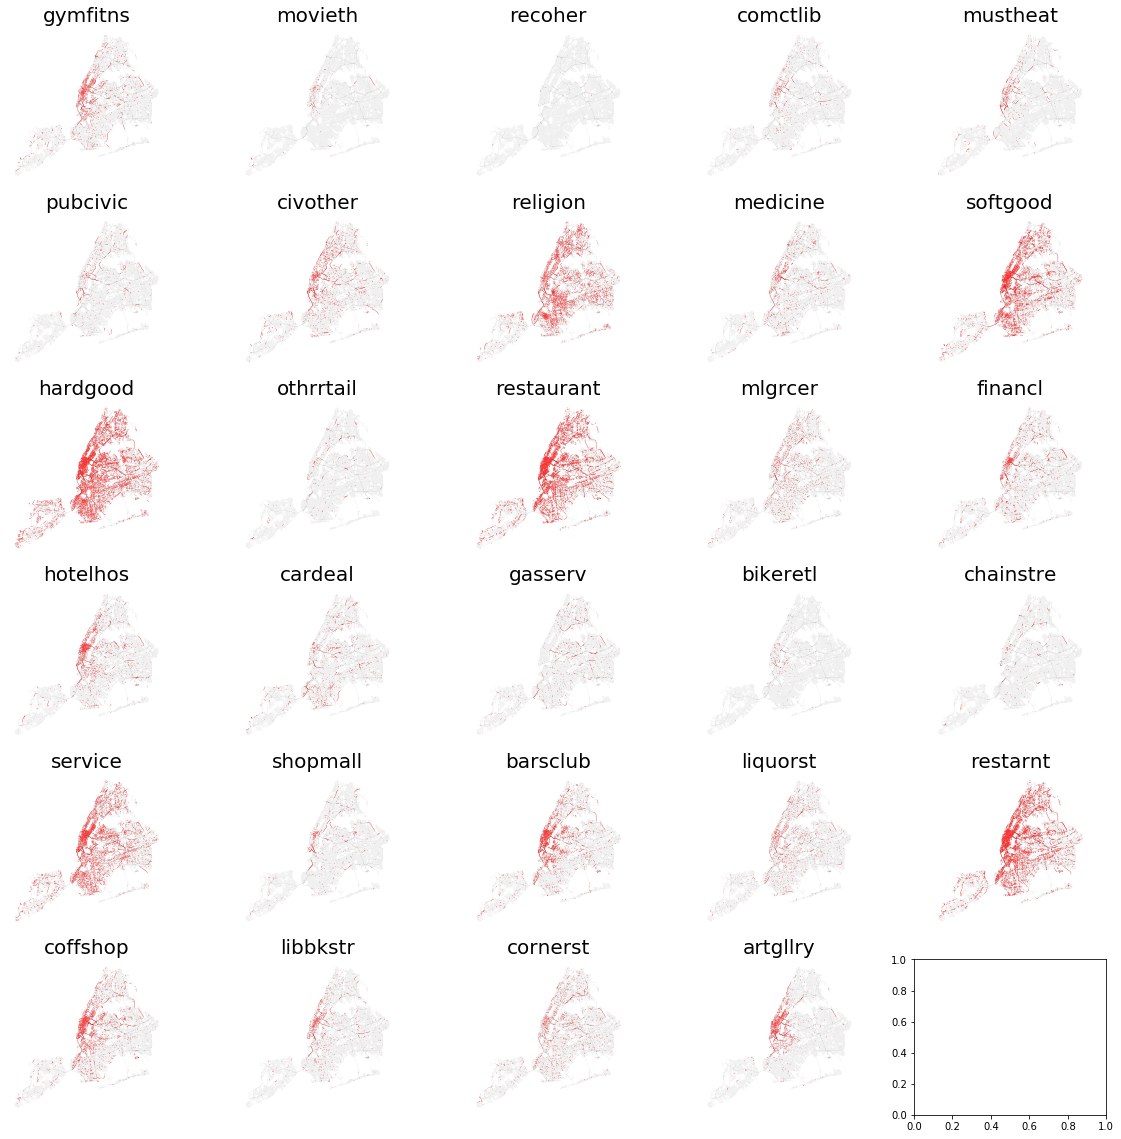

In [132]:
fig, axes = plt.subplots(ncols=5, nrows=6, figsize=(20,20))

for i, var in enumerate(variables):
    ax = axes.flatten()[i]
    segs_joined[segs_joined[var] == 1].plot(color='red', ax= ax, lw=0.3, zorder=-1, alpha=1)
    segs_joined[segs_joined[var] == 0].plot(color='grey', ax= ax, lw=0.1, zorder=-1, alpha=0.3)
    ax.set_title(var, fontsize=20)
    ax.axis('off')

plt.show()